In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pylab import rcParams

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, f1_score

In [3]:
cancer = load_breast_cancer()

# 4. Установка порогового значения по вероятности

Изначально порог принятия реения для решающей функции задан 0: 

* при значении решающей функции < 0, объект относится к классу 0

* при значении решающей функции > 0, объект относится к классу 1


Для вероятности установлен порог принятия решений = 0.5:

* при вероятности < 0.5, объект относится к классу 0 (модель уверена меньше)
* при вероятности > 0.5, объект относится к классу 1 (модель уверена больше)

Эти параметры можно менять для оптимизации модели под требования бизнес задачи.

В исследуемом наборе имеется 2 класса: 
* 'malignant' = 0 (злокачественные опухоли) 
* 'benign' = 1 (доброкачественные опухоли) 

Поставим перед собой следующую задачу: минимизировать долю ложно-положительных результатов, т.е. тех случаев, когда алгоритм предсказывает, что опухоль яв-ся доброкачественной (1), а на самом деле опухоль яв-ся злокачественной (0). В таком случае мы хотим быть уверены, что те пациенты, у кого высокая вероятность доброкачественной опухоли, буду определены алгоритмом точно. Тогда модель должна иметь бОльший порог уверенности, относя пациента к классу 1 и стремиться к 100%  точности в этм классе.

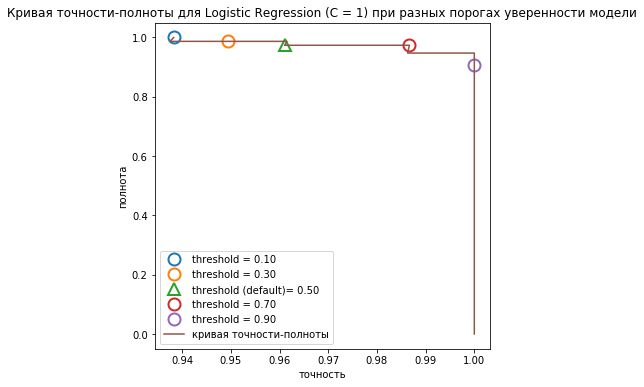

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

# изначально порог на decision_function = 0, redict_proba = 0.5

log_reg = LogisticRegression(C = 1, max_iter= 20000) 
log_reg.fit(X_train, y_train) 

precision, recall, tresholds = precision_recall_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])

rcParams['figure.figsize'] = 6, 6
for i in np.arange(0.1,1,0.2):
    if round(i,1) == 0.5:
        close_point = np.argmin(np.abs(tresholds - i))
        plt.plot(precision[close_point], recall[close_point], '^',
                 markersize=12, label="threshold (default)= {:.2f}".format(i), fillstyle="none", mew=2) 
    else:
        close_point = np.argmin(np.abs(tresholds - i))
        plt.plot(precision[close_point], recall[close_point], 'o',
             markersize=12, label="threshold = {:.2f}".format(i), fillstyle="none", mew=2) 
    
plt.plot(precision, recall, label = 'кривая точности-полноты')
plt.xlabel('точность')
plt.ylabel('полнота')
plt.title('Кривая точности-полноты для Logistic Regression (C = 1) при разных порогах уверенности модели')
plt.legend(loc = 'best')
plt.show()

Выведем сводку по показателям точности, полноты и их гармонического среднего (f-меры).

Видим, что алгоритм очень хорошо (100%) определяет пациентов с доброкачественной опухолью и отлично выявляет всех больных пациентов.

In [7]:
print('tresholds = 0.5')
print(classification_report(y_valid,log_reg.predict(X_valid))) 
print()
print('tresholds = 0.7')
y_pred_rise_threshold = log_reg.predict_proba(X_valid) >= 0.7
print(classification_report(y_valid,y_pred_rise_threshold[:,1]))

tresholds = 0.5
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.97      0.97      0.97        76

    accuracy                           0.96       107
   macro avg       0.95      0.95      0.95       107
weighted avg       0.96      0.96      0.96       107


tresholds = 0.7
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        31
           1       0.99      0.97      0.98        76

    accuracy                           0.97       107
   macro avg       0.96      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107



При значении порога вероятности равному 0.5 модель дает самые лучшие показатели

## 4.1. Зависиомсть f1 и точности от величины порога принятия решения

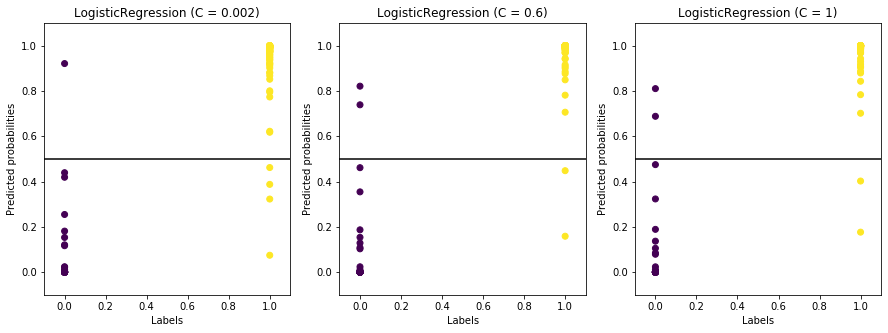

In [10]:
# порог T: все объекты, имеющие предсказание выше порога, относят к классу 1, остальные - к классу 0.
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

for c, ax in zip([0.002, 0.6, 1], axes):
    
    log_reg = LogisticRegression(C = c, max_iter = 20000).fit(X_train,y_train)
    predicted = log_reg.predict_proba(X_valid)[:,1]
    actual = y_valid
    ax.scatter(actual,predicted, c = actual)
    ax.plot([-0.1, 1.1], [0.5, 0.5], c = 'black') # уровень порога
    ax.axis([-0.1, 1.1, -0.1, 1.1])
    ax.set_title("LogisticRegression (C = {})".format(c))
    ax.set_xlabel("Labels")
    ax.set_ylabel("Predicted probabilities")

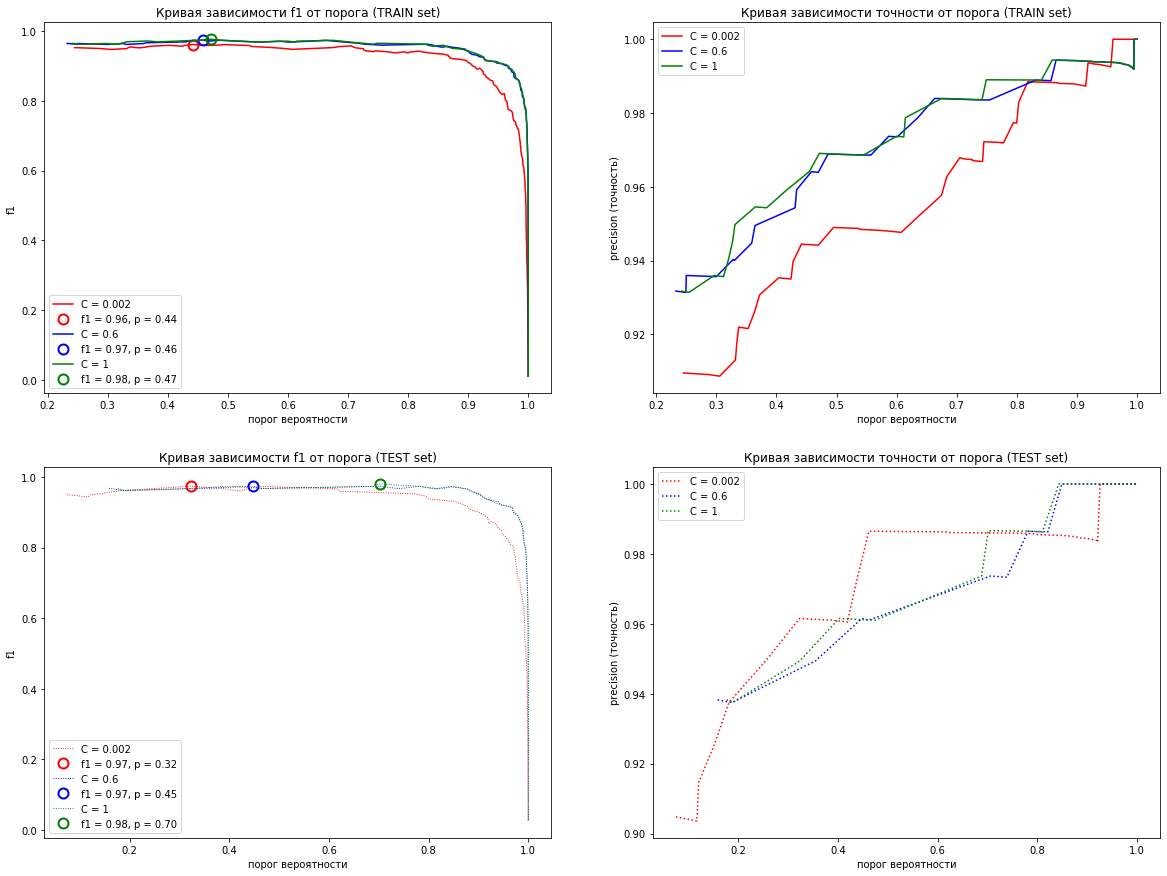

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15)) 

for c, col in zip([0.002, 0.6, 1], ['r','b','g']):
    log_reg = LogisticRegression(C = c,max_iter = 20000).fit(X_train,y_train)
    
    precision_train, recall_train, tresholds_train = precision_recall_curve(y_train, log_reg.predict_proba(X_train)[:,1])
    precision, recall, tresholds = precision_recall_curve(y_valid, log_reg.predict_proba(X_valid)[:,1])
    
    f_scores = []
    f_scores_train = []
    for i in tresholds:
        y_pred_change_threshold = log_reg.predict_proba(X_valid) >= i
        f_scores.append(f1_score(y_valid,y_pred_change_threshold[:,1]))
    for t in tresholds_train:
        y_pred_change_threshold_train = log_reg.predict_proba(X_train) >= t
        f_scores_train.append(f1_score(y_train,y_pred_change_threshold_train[:,1]))   
        
    max_f1 = np.argmax(np.abs(f_scores))
    max_f1_train = np.argmax(np.abs(f_scores_train))
    
    axes[0][0].plot(tresholds_train, f_scores_train, label = 'C = {}'.format(c), c = col)
    axes[0][0].plot(tresholds_train[max_f1_train], f_scores_train[max_f1_train],'o', markersize=10, 
             label="f1 = {:.2f}, p = {:.2f}".format(f_scores_train[max_f1_train],tresholds_train[max_f1_train]), 
             fillstyle="none",mew=2, c = col)
    
    axes[1][0].plot(tresholds, f_scores, label = 'C = {}'.format(c), linestyle='dotted', c = col,linewidth = 0.9)
    axes[1][0].plot(tresholds[max_f1], f_scores[max_f1],'o', markersize=10, 
                    label="f1 = {:.2f}, p = {:.2f}".format(f_scores[max_f1],tresholds[max_f1]), 
                    fillstyle="none",mew=2, c = col)
    
    axes[0][0].set_title('Кривая зависимости f1 от порога (TRAIN set)')
    axes[1][0].set_title('Кривая зависимости f1 от порога (TEST set)')
    axes[0][0].set_xlabel('порог вероятности')
    axes[0][0].set_ylabel('f1')
    axes[0][0].legend(loc = 'best') 
    
    axes[1][0].set_xlabel('порог вероятности')
    axes[1][0].set_ylabel('f1')
    axes[1][0].legend(loc = 'best')
    
    max_precision = np.argmax(np.abs(precision))
    #max_precision_train = np.argmax(np.abs(precision_train))
    
    axes[0][1].plot(tresholds_train, precision_train[:-1], label = 'C = {}'.format(c), c = col)
    #axes[0][1].plot(tresholds_train[max_precision_train], precision_train[:-1][max_precision_train],'o', markersize=10, 
             #label="p = {:.2f}".format(tresholds_train[max_precision_train]), fillstyle="none",mew=2, c = col)
    
    axes[1][1].plot(tresholds, precision[:-1], label = 'C = {}'.format(c), linestyle='dotted', c = col)
    #axes[1][1].plot(tresholds[max_precision], precision[:-1][max_precision],'o', markersize=10, 
             #label="p = {:.2f}".format(tresholds[max_precision]), fillstyle="none",mew=2, c = col)
   
    axes[0][1].set_title('Кривая зависимости точности от порога (TRAIN set)' )
    axes[0][1].set_xlabel('порог вероятности')
    axes[0][1].set_ylabel('precision (точность)')
    axes[0][1].legend(loc = 'best')   
    
    axes[1][1].set_title('Кривая зависимости точности от порога (TEST set)' )
    axes[1][1].set_xlabel('порог вероятности')
    axes[1][1].set_ylabel('precision (точность)')
    axes[1][1].legend(loc = 'best') 
plt.show()